## Plan of Action


1.   Load **Training.1600000.processed.noemoticon.csv Dataset (1.6 Mn twitter tweets)**
2.   **Pre-process dataset** by removing special characters, numbers, etc. from user reviews + convert **sentiment labels** positive & negative to numbers 1 & 0, respectively
3.   **Import GloVe Word Embedding** to build Embedding Dictionary + Use this to build Embedding Matrix for our Corpus
4. Model Training using **Deep Learning in Keras** for separate: **Simple Neural Net, CNN, LSTM and DistilBERT Models** and analyse model performance and results
4. Last, perform **predictions on real L&T tweets**

In [1]:
import tensorflow as tf

# Check if GPU is available
print("GPU is available" if tf.config.list_physical_devices('GPU') else "GPU is NOT available")


GPU is NOT available


## Setting the environment

In [2]:
# # Mounting google drive

# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# # Setting toolkit folder as working directory

# %cd /content/drive/My Drive/Project8_SentimentAnalysis_with_NeuralNetwork
# ! ls

In [4]:
# Importing essential libraries and functions

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import tensorflow as tf

In [5]:
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

In [6]:
from keras_preprocessing.sequence import pad_sequences

## Loading dataset

In [7]:
# Importing IMDb Movie Reviews dataset

movie_reviews = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding="iso-8859-1")

# dataset source: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [8]:
df=movie_reviews

In [9]:
df

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [10]:
column_names = ['sentiment','ID', 'Date', 'Query','Twitter Handle','Tweet']
df.columns = column_names

In [11]:
df.drop(columns=['ID','Date','Query','Twitter Handle'],inplace=True)

In [12]:
df['sentiment'].value_counts()
movie_reviews=df

In [13]:
# Dataset exploration

movie_reviews.shape

(1599999, 2)

In [14]:
movie_reviews.head(5)

,sentiment,Tweet
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


In [15]:
# Checking for missing values

movie_reviews.isnull().values.any()

False

In [16]:
df=pd.read_csv('sent_train.csv')

In [17]:
df

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0
...,...,...
9538,The Week's Gainers and Losers on the Stoxx Eur...,2
9539,Tupperware Brands among consumer gainers; Unil...,2
9540,vTv Therapeutics leads healthcare gainers; Myo...,2
9541,"WORK, XPO, PYX and AMKR among after hour movers",2


<Axes: xlabel='sentiment', ylabel='count'>

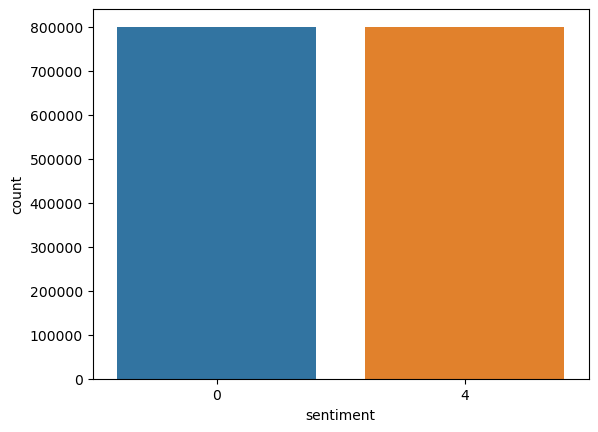

In [18]:
# Let's observe distribution of positive / negative sentiments in dataset

import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

## Data Preprocessing

In [19]:
movie_reviews["Tweet"][2]

# You can see that our text contains punctuations, brackets, HTML tags and numbers 
# We will preprocess this text in the next section

'my whole body feels itchy and like its on fire '

In [20]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vhema\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
# import b2_preprocessing_function
from b2_preprocessing_function import CustomPreprocess

In [22]:
custom = CustomPreprocess()
custom.preprocess_text("Those were the best days of my life!")

'best days life '

In [23]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [24]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vhema\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [25]:
from nltk.stem import PorterStemmer 
port_stem=PorterStemmer()

def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower()
    
    sentence=[port_stem.stem(word) for word in sentence if not word in stopwords.word('english')]

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [26]:
# Calling preprocessing_text function on movie_reviews

X = []
sentences = list(movie_reviews['Tweet'])
for sen in sentences:
    X.append(custom.preprocess_text(sen))

In [27]:
# Sample cleaned up movie review 

X[2]

'whole body feels itchy like fire '

In [28]:
XX=[]
sentences = list(df['text'])
for sen in sentences:
    XX.append(custom.preprocess_text(sen))

In [29]:
X.extend(XX)

In [30]:
# Converting sentiment labels to 0 & 1

y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x==4 else 0, y)))

In [31]:
yy=df['label']

yy = np.array(list(map(lambda x: 1 if x==2 else 0, yy)))

In [32]:
y=np.concatenate((y, yy))

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# The train set will be used to train our deep learning models 
# while test set will be used to evaluate how well our model performs 

## Preparing embedding layer

Let's now write the script for our embedding layer. Embedding layer converts our textual data into numeric form. It is then **used as the first layer for the deep learning models in Keras**.

In [34]:
# Embedding layer expects the words to be in numeric form 
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer 
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [35]:
import io
import json

In [36]:
# Saving
tokenizer_json = word_tokenizer.to_json()
with io.open('b3_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [37]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

514982

In [38]:
# Padding all reviews to fixed length 30

maxlen = 30

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [39]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.300d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [40]:
# Create Embedding Matrix having 300 columns 
# Containing 300-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 300))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [41]:
embedding_matrix.shape

(514982, 300)

# Model Training with:

## Simple Neural Network

In [42]:
# Neural Network architecture

snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 300, weights=[embedding_matrix], input_length=maxlen , trainable=False)

# Embedding(input_dim=Vocab_size,output_dim=8,input_length=max_length)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [43]:
# Model compiling

snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 300)           154494600 
                                                                 
 flatten (Flatten)           (None, 9000)              0         
                                                                 
 dense (Dense)               (None, 1)                 9001      
                                                                 
Total params: 154503601 (589.38 MB)
Trainable params: 9001 (35.16 KB)
Non-trainable params: 154494600 (589.35 MB)
_________________________________________________________________
None


In [48]:
# Model training

snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
8048/8048 [==============================] - 30s 4ms/step - loss: 0.5640 - acc: 0.7142 - val_loss: 0.5667 - val_acc: 0.7146
Epoch 2/10
8048/8048 [==============================] - 31s 4ms/step - loss: 0.5629 - acc: 0.7151 - val_loss: 0.5655 - val_acc: 0.7145
Epoch 3/10
8048/8048 [==============================] - 29s 4ms/step - loss: 0.5625 - acc: 0.7151 - val_loss: 0.5657 - val_acc: 0.7148
Epoch 4/10
8048/8048 [==============================] - 30s 4ms/step - loss: 0.5622 - acc: 0.7155 - val_loss: 0.5671 - val_acc: 0.7125
Epoch 5/10
8048/8048 [==============================] - 30s 4ms/step - loss: 0.5619 - acc: 0.7158 - val_loss: 0.5648 - val_acc: 0.7147
Epoch 6/10
8048/8048 [==============================] - 30s 4ms/step - loss: 0.5617 - acc: 0.7158 - val_loss: 0.5649 - val_acc: 0.7155
Epoch 7/10
8048/8048 [==============================] - 31s 4ms/step - loss: 0.5615 - acc: 0.7162 - val_loss: 0.5651 - val_acc: 0.7156
Epoch 8/10
8048/8048 [==============================] -

In [49]:
# # Model training

# snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

In [50]:
# Predictions on the Test Set

score = snn_model.evaluate(X_test, y_test, verbose=1)

10060/10060 [==============================] - 19s 2ms/step - loss: 0.5656 - acc: 0.7143


In [51]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5656214952468872
Test Accuracy: 0.7143416404724121


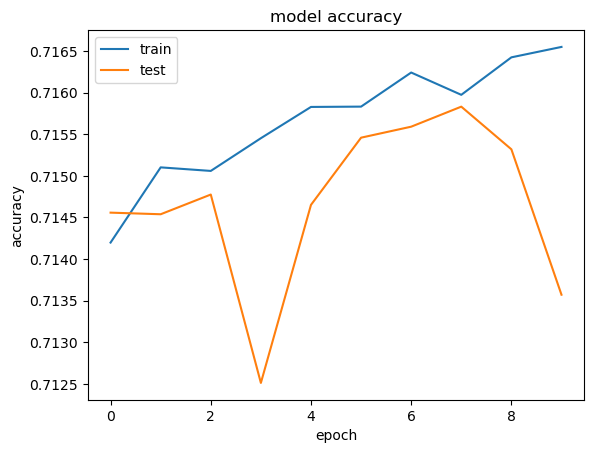

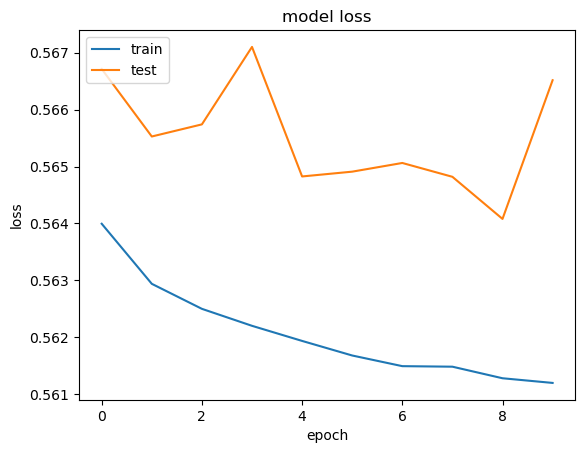

In [52]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Convolutional Neural Network

In [53]:
from keras.layers import Conv1D

In [54]:
# Neural Network architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 300, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [55]:
# Model compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 30, 300)           154494600 
                                                                 
 conv1d (Conv1D)             (None, 26, 128)           192128    
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 154686857 (590.08 MB)
Trainable params: 192257 (751.00 KB)
Non-trainable params: 154494600 (589.35 MB)
_________________________________________________________________
None


In [57]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
8048/8048 [==============================] - 233s 29ms/step - loss: 0.4023 - acc: 0.8154 - val_loss: 0.5046 - val_acc: 0.7629
Epoch 2/6
8048/8048 [==============================] - 238s 30ms/step - loss: 0.3953 - acc: 0.8197 - val_loss: 0.5074 - val_acc: 0.7620
Epoch 3/6
8048/8048 [==============================] - 248s 31ms/step - loss: 0.3891 - acc: 0.8228 - val_loss: 0.5169 - val_acc: 0.7599
Epoch 4/6
8048/8048 [==============================] - 1047s 130ms/step - loss: 0.3838 - acc: 0.8259 - val_loss: 0.5182 - val_acc: 0.7606
Epoch 5/6
8048/8048 [==============================] - 286s 36ms/step - loss: 0.3786 - acc: 0.8287 - val_loss: 0.5253 - val_acc: 0.7571
Epoch 6/6
8048/8048 [==============================] - 300s 37ms/step - loss: 0.3744 - acc: 0.8308 - val_loss: 0.5329 - val_acc: 0.7572


In [58]:
# Predictions on the Test Set
score = cnn_model.evaluate(X_test, y_test, verbose=1)

10060/10060 [==============================] - 47s 5ms/step - loss: 0.5338 - acc: 0.7567


In [59]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.533781886100769
Test Accuracy: 0.7567014098167419


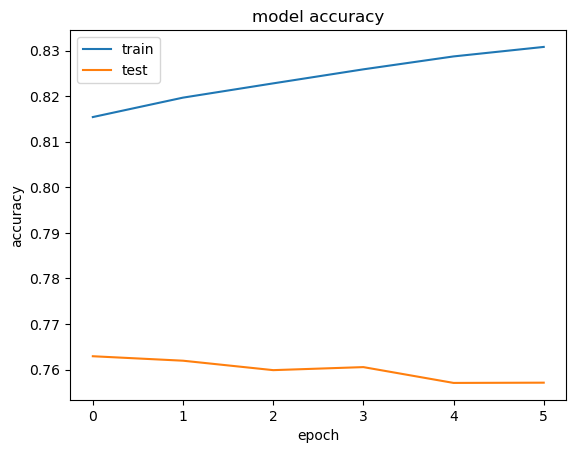

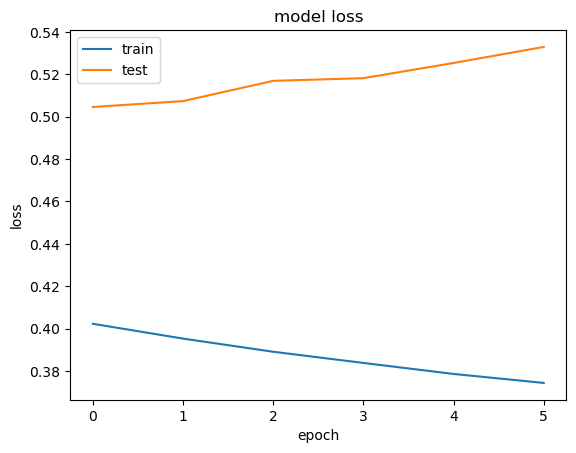

In [60]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

## Recurrent Neural Network (LSTM)

In [61]:
import pandas as pd
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import matplotlib.pyplot as plt

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vhema\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vhema\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


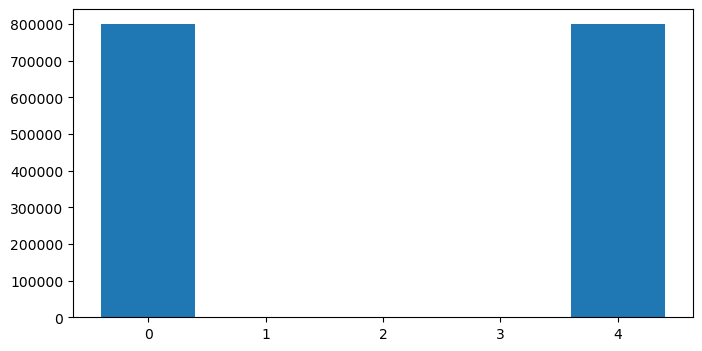

In [91]:
import pandas as pd
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
import matplotlib.pyplot as plt

nltk.download('stopwords')

# Load dataset
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='iso-8859-1')
df.columns = ['sentiment', 'id', 'date', 'query', 'user_name', 'tweet']
df = df.drop(['id', 'date', 'query', 'user_name'], axis=1)

# Define label-to-sentiment mapping
label_to_sentiment = {0: "Negative", 4: "Positive"}

# Clean tweets
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
text_cleaning_regex = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def clean_tweets(text, stem=False):
    text = re.sub(text_cleaning_regex, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

df['tweet'] = df['tweet'].apply(clean_tweets)

# Train-test split
train_data, test_data = train_test_split(df, test_size=0.2, random_state=16)

# Tokenization and padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['tweet'])
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data['tweet']), maxlen=30)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data['tweet']), maxlen=30)

# Label encoding
encoder = LabelEncoder()
y_train = encoder.fit_transform(train_data['sentiment']).reshape(-1, 1)
y_test = encoder.transform(test_data['sentiment']).reshape(-1, 1)

# Load GloVe embeddings
embeddings_index = {}
with open('glove.6B.300d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Define embedding layer
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen , trainable=False)

# Plot distribution of sentiment labels
distribution = df['sentiment'].value_counts()
plt.figure(figsize=(8, 4))
plt.bar(distribution.index, distribution.values)
plt.show()


In [92]:
# # Import various layers needed for the architecture from keras
# from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
# from tensorflow.keras.layers import SpatialDropout1D
# from tensorflow.keras.callbacks import ModelCheckpoint
# # The Input layer 
# sequence_input = Input(shape=(100,), dtype='int32')
# # Inputs passed to the embedding layer
# embedding_sequences = embedding_layer(sequence_input)
# # dropout and conv layer 
# x = SpatialDropout1D(0.2)(embedding_sequences)
# x = Conv1D(64, 5, activation='tanh')(x)
# # Passed on to the LSTM layer
# x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
# x = Dense(512, activation='tanh')(x)
# x = Dropout(0.5)(x)
# x = Dense(512, activation='tanh')(x)
# # Passed on to activation layer to get final output
# outputs = Dense(1, activation='sigmoid')(x)
# model = tf.keras.Model(sequence_input, outputs)
# Define embedding layer
# embedding_layer = Embedding(input_dim=vocab_size, output_dim=300 , trainable=False)
# embedding_layer.build((1,))
# embedding_layer.set_weights([embedding_matrix])

In [93]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

# Assuming 'embedding_layer' is defined earlier in your code
# Define input layer
sequence_input = Input(shape=(30,), dtype='int32')

# Inputs passed to the embedding layer
embedding_sequences = embedding_layer(sequence_input)

# Dropout and convolutional layer 
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)  # Using ReLU activation instead of tanh

# Passed on to the LSTM layer
# Adjusting LSTM parameters to meet cuDNN criteria
x = Bidirectional(LSTM(64, return_sequences=True))(x)  # Set return_sequences=True
x = Dropout(0.2)(x)  # Reducing dropout rate to 0.2

# GlobalMaxPooling1D layer to reduce dimensionality
x = tf.keras.layers.GlobalMaxPooling1D()(x)

# Adding Dense layers
x = Dense(512, activation='relu')(x)  # Using ReLU activation instead of tanh
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)  # Using ReLU activation instead of tanh

# Passed on to the activation layer to get the final output
outputs = Dense(1, activation='sigmoid')(x)

# Define the model
model = tf.keras.Model(sequence_input, outputs)


In [94]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
LR=0.001
model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,min_lr = 0.01, monitor = 'val_loss',verbose = 1)
training = model.fit(x_train, y_train, batch_size=1024, epochs=10,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10
1250/1250 [==============================] - 777s 618ms/step - loss: 0.5139 - accuracy: 0.7428 - val_loss: 0.4819 - val_accuracy: 0.7661 - lr: 0.0010
Epoch 2/10
1250/1250 [==============================] - 678s 543ms/step - loss: 0.4819 - accuracy: 0.7659 - val_loss: 0.4726 - val_accuracy: 0.7729 - lr: 0.0010
Epoch 3/10
1250/1250 [==============================] - 642s 514ms/step - loss: 0.4712 - accuracy: 0.7730 - val_loss: 0.4684 - val_accuracy: 0.7754 - lr: 0.0010
Epoch 4/10
1250/1250 [==============================] - 654s 523ms/step - loss: 0.4644 - accuracy: 0.7772 - val_loss: 0.4647 - val_accuracy: 0.7782 - lr: 0.0010
Epoch 5/10
1250/1250 [==============================] - 660s 528ms/step - loss: 0.4594 - accuracy: 0.7801 - val_loss: 0.4659 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 6/10
1250/1250 [==============================] - 666s 533ms/step - loss: 0.4560 - accuracy: 0.7823 - val_loss: 0.4647 - val_accuracy: 0.7800 - lr: 0.0010
Epoch 7/10
1250/1250 [============

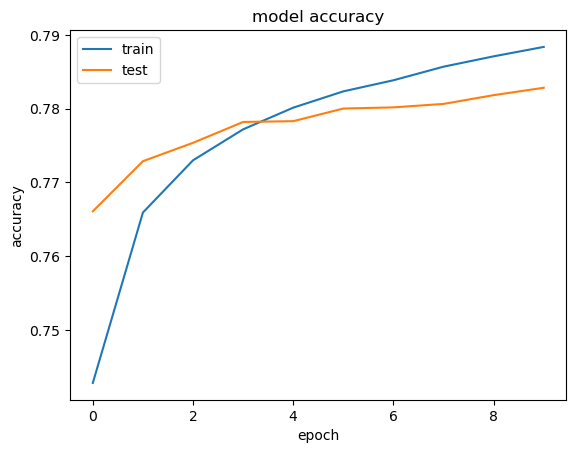

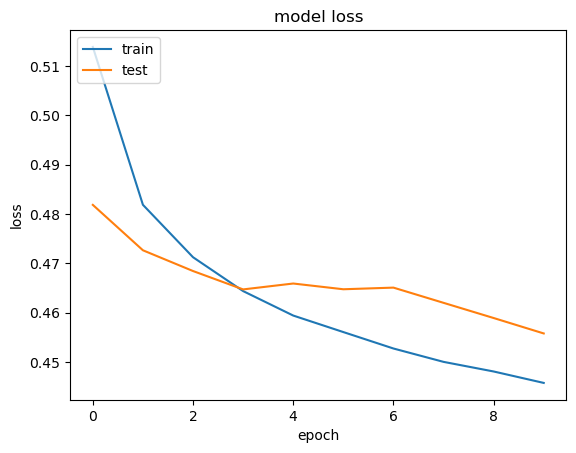

In [100]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [96]:
model

## Making Predictions on Live L&T tweet data

In [35]:
pwd # lists files in working directory

'/Users/guptatilak/Documents/SentimentAnalysis-Createch/sentiment-analysis'

In [36]:
# Load previously trained LSTM Model

from keras.models import load_model

model_path ='lstm_model2.h5'
pretrained_lstm_model = load_model(model_path)
pretrained_cnn_model = load_model('cnn_model.h5')
pretrained_snn_model = load_model('snn_model.h5')

# # summarize model
# pretrained_lstm_model.summary()

In [2]:
# Load sample IMDb reviews csv, having ~6 movie reviews, along with their IMDb rating
import pandas as pd
sample_reviews = pd.read_csv("twitter_LT.csv")

sample_reviews.head(6)

,position,title,snippet,link,displayed_link,highlighs
0,0,Larsen & Toubro (@larsentoubro) / ...,The official Larsen & Toubro Corporate handle....,https://twitter.com/larsentoubro,https://twitter.com › larsentoubro,NaN
1,1,L&T Technology Services (LTTS) (@LnTTechservic...,We are a global leader in Engineering and R&D ...,https://twitter.com/LnTTechservices,https://twitter.com › LnTTechservices,NaN
2,2,Financial Express,@larsentoubro. ) announced that its Hydrocarbo...,https://twitter.com/FinancialXpress/status/176...,https://twitter.com › FinancialXpress › status,['larsentoubro']
3,3,Financial Express,@larsentoubro. ) announced that it has bagged ...,https://twitter.com/FinancialXpress/status/176...,https://twitter.com › FinancialXpress › status,['larsentoubro']
4,4,Financial Express,@larsentoubro. ) announced that its Hydrocarbo...,https://twitter.com/FinancialXpress/status/175...,https://twitter.com › FinancialXpress › status,['larsentoubro']
5,5,CNBC-TV18,@larsentoubro. ) slumps after news reports sug...,https://twitter.com/CNBCTV18News/status/175944...,https://twitter.com › status,['larsentoubro']


In [3]:
sample_reviews[sample_reviews['snippet'].isnull()]

,position,title,snippet,link,displayed_link,highlighs
8,8,"L&T Technology Services (LTTS) on X: ""Get read...",NaN,https://twitter.com/LnTTechservices/status/175...,https://twitter.com › LnTTechservices › status...,NaN


In [4]:
sample_reviews=sample_reviews[~sample_reviews['snippet'].isnull()]

In [5]:
unseen_reviews = sample_reviews['snippet']
from b2_preprocessing_function import CustomPreprocess
custom=CustomPreprocess()

# Assuming unseen_reviews is your DataFrame column with text data
unseen_processed = []

for review in unseen_reviews:
    # Check if review is a string, if not, convert it to a string
    if isinstance(review, str):
        review = custom.preprocess_text(review)
    else:
        review = str(review)  # Convert non-string values to string
        review = custom.preprocess_text(review)
    unseen_processed.append(review)


In [6]:
unseen_processed

['official larsen toubro corporate handle follow us latest news announcements upcoming events ',
 'global leader engineering er services visit https co nu q information engineeringthechange ',
 ' larsentoubro announced hydrocarbon vertical secured significant order ongc mhn tcpp pgc bgc project mtpbp ',
 ' larsentoubro announced bagged major contract ministry defence government india supply high ',
 ' larsentoubro announced hydrocarbon vertical secured onshore order offshore order prestigious client ',
 ' larsentoubro slumps news reports suggest saudi aramco defers bid process bn orders safaniyah oilfield projects ',
 'larsen toubro indian multinational engaged epc projects commissioned first indigenously manufactured electrolyser ',
 'cnbctv market shares larsen toubro larsentoubro fell fy revenue beat street estimates lower expected ',
 'every step larsentoubro brings mumbai spirit life lntseabridgemarathon readytorun stridesformumbai ',
 'larsen toubro commissions first indigenously

In [7]:
from keras_preprocessing.text import tokenizer_from_json

In [8]:
# Loading
import json
with open('b3_tokenizer.json') as f:
    data = json.load(f)
    loaded_tokenizer = tokenizer_from_json(data)

In [9]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = loaded_tokenizer.texts_to_sequences(unseen_processed)

In [10]:
unseen_tokenized

[[1300, 65649, 5522, 1790, 144, 105, 1610, 321, 10018, 3738, 2535],
 [3023, 5073, 9534, 1507, 3432, 541, 371, 289, 3907, 2485, 3020],
 [4088, 15841, 16470, 10114, 841, 281528, 130123, 294985, 74398, 772],
 [4088, 20592, 1116, 2989, 9404, 18948, 4534, 2302, 5093, 471],
 [4088, 15841, 16470, 158690, 841, 24430, 841, 84296, 1774],
 [56482, 321, 2378, 3119, 9714, 31835, 5844, 2223, 6416, 3961, 128708, 2543],
 [65649, 3169, 289574, 7227, 51263, 2543, 42529, 88, 46138],
 [442058, 1237, 3002, 65649, 661, 9962, 4700, 771, 1064, 12331, 2947, 1860],
 [277, 1405, 2225, 6510, 2707, 91],
 [65649, 24835, 88, 46138, 134454],
 [2033, 9215, 14, 26329, 6302, 1545, 11516, 6559, 5333, 3070, 17354, 9978],
 [4088, 15841, 1802, 16470, 2354, 158690, 772, 178272, 18244, 3299],
 [2141, 785, 2309, 1142, 2468],
 [3453, 4379, 2378, 1207, 1642, 5005],
 [2154, 3961, 1091, 1756, 792, 17, 6730, 3955],
 [49967, 1600, 389499, 7004, 573, 467960, 317, 14, 5431, 25514],
 [1118, 45793, 84296, 772, 88774, 3071, 739, 3299],
 

In [11]:
# Pooling instance to have maxlength of 30 tokens
from keras.preprocessing.sequence import pad_sequences
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=30)

In [12]:
unseen_padded

array([[  1300,  65649,   5522, ...,      0,      0,      0],
       [  3023,   5073,   9534, ...,      0,      0,      0],
       [  4088,  15841,  16470, ...,      0,      0,      0],
       ...,
       [134217,  20027,   7813, ...,      0,      0,      0],
       [  3503,   1827,   5638, ...,      0,      0,      0],
       [    10,   1373,   1642, ...,      0,      0,      0]], dtype=int32)

In [13]:
# Passing tokenised instance to the LSTM model for predictions
unseen_sentiments_snn = pretrained_snn_model.predict(unseen_padded)

unseen_sentiments_cnn = pretrained_cnn_model.predict(unseen_padded)

unseen_sentiments_lstm = pretrained_lstm_model.predict(unseen_padded)

2024-03-24 10:59:57.102832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 18ms/step


2024-03-24 10:59:58.063186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 145ms/step


2024-03-24 10:59:59.392103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-24 10:59:59.534806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-24 10:59:59.611750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 2s 236ms/step


In [14]:
unseen_sentiments_lstm

array([[9.9999940e-01],
       [9.9973410e-01],
       [9.9992347e-01],
       [5.4984572e-05],
       [8.5752362e-01],
       [8.4617537e-01],
       [9.9928170e-01],
       [9.4250163e-09],
       [9.7778475e-01],
       [9.9909806e-01],
       [3.1686902e-01],
       [1.0811734e-07],
       [3.6157059e-04],
       [3.2758158e-01],
       [9.9979931e-01],
       [9.4731911e-07],
       [9.9424946e-01],
       [9.9999356e-01],
       [9.9999702e-01],
       [9.9998486e-01],
       [6.2555663e-02],
       [1.3292804e-02],
       [9.9999750e-01],
       [9.9997306e-01],
       [4.2312969e-02],
       [8.4397294e-07],
       [3.8027018e-03],
       [1.3786045e-07],
       [9.9999571e-01],
       [9.9999917e-01],
       [1.1259439e-04],
       [9.9999976e-01],
       [1.8068112e-02],
       [9.9983072e-01],
       [9.9999988e-01],
       [1.0000000e+00],
       [7.4797696e-01],
       [9.9550700e-01],
       [1.0000000e+00],
       [9.3890643e-01],
       [9.9503541e-01],
       [9.999831

In [15]:
# Writing model output file back to Google Drive
import numpy as np
sample_reviews['Predicted Sentiments SNN'] = np.round(unseen_sentiments_snn*10,1)
sample_reviews['Predicted Sentiments CNN'] = np.round(unseen_sentiments_cnn*10,1)
sample_reviews['Predicted Sentiments LSTM'] = np.round(unseen_sentiments_lstm*10,1)

df_prediction_sentiments_snn = pd.DataFrame(sample_reviews['Predicted Sentiments SNN'], columns = ['Predicted Sentiments SNN'])
df_prediction_sentiments_cnn = pd.DataFrame(sample_reviews['Predicted Sentiments CNN'], columns = ['Predicted Sentiments CNN'])
df_prediction_sentiments_lstm = pd.DataFrame(sample_reviews['Predicted Sentiments LSTM'], columns = ['Predicted Sentiments LSTM'])
df_tweet                 = pd.DataFrame(sample_reviews['snippet'], columns = ['snippet'])
# df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
# df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_tweet, df_prediction_sentiments_snn,df_prediction_sentiments_cnn,df_prediction_sentiments_lstm], axis=1)

# dfx.to_csv("c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')

dfx.head(50)

,snippet,Predicted Sentiments SNN,Predicted Sentiments CNN,Predicted Sentiments LSTM
0,The official Larsen & Toubro Corporate handle....,5.1,2.9,10.0
1,We are a global leader in Engineering and R&D ...,8.2,7.9,10.0
2,@larsentoubro. ) announced that its Hydrocarbo...,7.4,3.9,10.0
3,@larsentoubro. ) announced that it has bagged ...,2.8,7.3,0.0
4,@larsentoubro. ) announced that its Hydrocarbo...,8.8,9.2,8.6
5,@larsentoubro. ) slumps after news reports sug...,2.3,0.2,8.5
6,Larsen & Toubro (L&T) an Indian multinational ...,5.6,0.3,10.0
7,CNBCTV18Market | Shares of Larsen & Toubro (@l...,2.6,0.8,0.0
9,"With every step, @larsentoubro brings Mumbai's...",8.7,9.4,9.8
10,Larsen & Toubro (L&T) commissions first indige...,2.5,2.8,10.0


In [16]:
pip install happytransformer

Note: you may need to restart the kernel to use updated packages.


In [17]:
from happytransformer import HappyTextClassification

/Users/guptatilak/anaconda3/lib/python3.10/site-packages/huggingface_hub/utils/_runtime.py:185: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(


In [18]:
happy_tc=HappyTextClassification(model_type='DISTILBERT', model_name='distilbert-base-uncased-finetuned-sst-2-english',num_labels=2)

In [19]:
result=happy_tc.classify_text(dfx['snippet'][45])

In [20]:
result

TextClassificationResult(label='NEGATIVE', score=0.9897340536117554)

In [21]:
dfx['snippet'][96]

'@larsentoubro. and his team; L&T is doing several projects in Tanzania in water, power and other sectors. Image. India in Tanzania and 5 others.'

In [22]:
dfx=dfx.dropna(subset=['snippet'])
snippets=list(dfx['snippet'])
result=[]
for snippet in snippets:
    prediction=(happy_tc.classify_text(snippet))
    if prediction.label == 'POSITIVE':
        result.append(np.round((prediction.score)*10,1))
    else:
        result.append(np.round((1-prediction.score)*10,1))

In [23]:
result

[9.9,
 9.9,
 1.0,
 0.3,
 9.2,
 0.0,
 8.8,
 0.0,
 10.0,
 0.7,
 1.0,
 9.3,
 2.6,
 8.2,
 9.9,
 9.9,
 10.0,
 0.9,
 0.1,
 0.3,
 1.6,
 0.1,
 0.2,
 0.1,
 9.9,
 0.4,
 0.2,
 8.9,
 10.0,
 0.3,
 10.0,
 0.2,
 0.1,
 9.6,
 7.3,
 10.0,
 0.4,
 9.9,
 10.0,
 0.5,
 0.2,
 0.1,
 0.0,
 0.1,
 0.1,
 0.1,
 9.7,
 1.1,
 9.9,
 10.0,
 9.8,
 10.0,
 10.0,
 0.0,
 10.0,
 9.8,
 0.0,
 0.7,
 2.5,
 0.0,
 0.1,
 7.2,
 9.6,
 0.1,
 10.0,
 0.7,
 0.0,
 10.0,
 10.0,
 9.3,
 0.0,
 10.0,
 4.8,
 4.0,
 9.9,
 10.0,
 0.1,
 1.6,
 2.3,
 0.0,
 10.0,
 9.6,
 0.1,
 0.1,
 6.8,
 0.2,
 9.9,
 0.6,
 0.1,
 9.7,
 0.1,
 10.0,
 0.3,
 2.1,
 2.0,
 9.7,
 0.1,
 9.9,
 10.0]

In [24]:
df_prediction_sentiments_distilbert = pd.DataFrame(result, columns = ['Predicted Sentiments DistilBERT'])

In [25]:
dfx=pd.concat([dfx,df_prediction_sentiments_distilbert], axis=1)

In [26]:
dfx

,snippet,Predicted Sentiments SNN,Predicted Sentiments CNN,Predicted Sentiments LSTM,Predicted Sentiments DistilBERT
0,The official Larsen & Toubro Corporate handle....,5.1,2.9,10.0,9.9
1,We are a global leader in Engineering and R&D ...,8.2,7.9,10.0,9.9
2,@larsentoubro. ) announced that its Hydrocarbo...,7.4,3.9,10.0,1.0
3,@larsentoubro. ) announced that it has bagged ...,2.8,7.3,0.0,0.3
4,@larsentoubro. ) announced that its Hydrocarbo...,8.8,9.2,8.6,9.2
...,...,...,...,...,...
96,@larsentoubro. and his team; L&T is doing seve...,2.7,1.4,10.0,0.1
97,@RailMinIndia · @AshwiniVaishnaw · @MBPatil · ...,1.6,6.5,10.0,9.9
98,"@larsentoubro. at Gogamukh, Dhemaji. Built at ...",2.4,0.8,0.0,10.0
99,Love & Trust are key words for our relationshi...,9.3,9.7,10.0,NaN


In [27]:
dfx.to_csv('test.csv',index=False)

## Saving models

In [101]:
# Saving the model as a h5 file for possible use later

# model.save(f"./lstm_model2.h5", save_format='h5')
# snn_model.save(f"./snn_model.h5", save_format='h5')
# cnn_model.save(f"./cnn_model.h5", save_format='h5')

C:\Users\vhema\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Combining predictions

In [28]:
dfx['avg-sentiment'] = np.round(np.mean([
    dfx['Predicted Sentiments SNN'],
    dfx['Predicted Sentiments CNN'],
    dfx['Predicted Sentiments LSTM'],
    dfx['Predicted Sentiments DistilBERT']
], axis=0))

In [29]:
dfx

,snippet,Predicted Sentiments SNN,Predicted Sentiments CNN,Predicted Sentiments LSTM,Predicted Sentiments DistilBERT,avg-sentiment
0,The official Larsen & Toubro Corporate handle....,5.1,2.9,10.0,9.9,7.0
1,We are a global leader in Engineering and R&D ...,8.2,7.9,10.0,9.9,9.0
2,@larsentoubro. ) announced that its Hydrocarbo...,7.4,3.9,10.0,1.0,6.0
3,@larsentoubro. ) announced that it has bagged ...,2.8,7.3,0.0,0.3,3.0
4,@larsentoubro. ) announced that its Hydrocarbo...,8.8,9.2,8.6,9.2,9.0
...,...,...,...,...,...,...
96,@larsentoubro. and his team; L&T is doing seve...,2.7,1.4,10.0,0.1,4.0
97,@RailMinIndia · @AshwiniVaishnaw · @MBPatil · ...,1.6,6.5,10.0,9.9,7.0
98,"@larsentoubro. at Gogamukh, Dhemaji. Built at ...",2.4,0.8,0.0,10.0,3.0
99,Love & Trust are key words for our relationshi...,9.3,9.7,10.0,NaN,NaN


In [30]:
import pandas as pd

# Assuming df is your DataFrame containing four numeric columns: col1, col2, col3, col4
# You can replace these with your actual column names
# You also need to define your custom weights for each column
custom_weights = {
    'Predicted Sentiments SNN': 0.1,
    'Predicted Sentiments CNN': 0.5,
    'Predicted Sentiments LSTM': 0.20,
    'Predicted Sentiments DistilBERT': 0.20
}

# Calculate the weighted average
def weighted_average(row):
    return np.round(sum(row[col] * custom_weights[col] for col in custom_weights.keys()))

# Create a new column 'weighted_avg' containing the weighted average
dfx['weighted_avg'] = dfx.apply(weighted_average, axis=1)

# Print the DataFrame to verify the changes
dfx


,snippet,Predicted Sentiments SNN,Predicted Sentiments CNN,Predicted Sentiments LSTM,Predicted Sentiments DistilBERT,avg-sentiment,weighted_avg
0,The official Larsen & Toubro Corporate handle....,5.1,2.9,10.0,9.9,7.0,6.0
1,We are a global leader in Engineering and R&D ...,8.2,7.9,10.0,9.9,9.0,9.0
2,@larsentoubro. ) announced that its Hydrocarbo...,7.4,3.9,10.0,1.0,6.0,5.0
3,@larsentoubro. ) announced that it has bagged ...,2.8,7.3,0.0,0.3,3.0,4.0
4,@larsentoubro. ) announced that its Hydrocarbo...,8.8,9.2,8.6,9.2,9.0,9.0
...,...,...,...,...,...,...,...
96,@larsentoubro. and his team; L&T is doing seve...,2.7,1.4,10.0,0.1,4.0,3.0
97,@RailMinIndia · @AshwiniVaishnaw · @MBPatil · ...,1.6,6.5,10.0,9.9,7.0,7.0
98,"@larsentoubro. at Gogamukh, Dhemaji. Built at ...",2.4,0.8,0.0,10.0,3.0,3.0
99,Love & Trust are key words for our relationshi...,9.3,9.7,10.0,NaN,NaN,NaN


In [31]:
dfx['overall-sentiment'] = np.where(dfx['weighted_avg'] >= 5, 4, 0)

In [32]:
dfx

,snippet,Predicted Sentiments SNN,Predicted Sentiments CNN,Predicted Sentiments LSTM,Predicted Sentiments DistilBERT,avg-sentiment,weighted_avg,overall-sentiment
0,The official Larsen & Toubro Corporate handle....,5.1,2.9,10.0,9.9,7.0,6.0,4
1,We are a global leader in Engineering and R&D ...,8.2,7.9,10.0,9.9,9.0,9.0,4
2,@larsentoubro. ) announced that its Hydrocarbo...,7.4,3.9,10.0,1.0,6.0,5.0,4
3,@larsentoubro. ) announced that it has bagged ...,2.8,7.3,0.0,0.3,3.0,4.0,0
4,@larsentoubro. ) announced that its Hydrocarbo...,8.8,9.2,8.6,9.2,9.0,9.0,4
...,...,...,...,...,...,...,...,...
96,@larsentoubro. and his team; L&T is doing seve...,2.7,1.4,10.0,0.1,4.0,3.0,0
97,@RailMinIndia · @AshwiniVaishnaw · @MBPatil · ...,1.6,6.5,10.0,9.9,7.0,7.0,4
98,"@larsentoubro. at Gogamukh, Dhemaji. Built at ...",2.4,0.8,0.0,10.0,3.0,3.0,0
99,Love & Trust are key words for our relationshi...,9.3,9.7,10.0,NaN,NaN,NaN,0


In [33]:
dfx.to_csv('predictions.csv',index=False)